In [1]:
# instalar as bibliotecas necessárias
#!pip install numpy pandas matplotlib scikit-learn tabletext scipy seaborn plotly

## Determinar a quantidade de Cluster para o algorítmo K-means

In [86]:
# importar bibliotecas
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

import scipy.stats

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from IPython.display import display,HTML
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots


In [3]:
#configurar tema dos gráficos
sns.set_theme()

In [48]:
def avaliar_opcoes_arranjo(qtd_min_clusters,qtd_max_clusters,dataset):
    # Definir range de clusters
    range_clusters = range(qtd_min_clusters,qtd_max_clusters+1)
    
    # Lista para armazenar os resultados da clusterização para cada arranjo
    resultados=[]
    
    for i,k in enumerate(range_clusters):
        resultado={"arranjo":f"{k} Grupos","qtd_grupos":k }
        
        #print("="*24)
        #print(f"Calculando K-Means para {k } clusters")
        #print("_"*24)
        # Criar um objeto KMeans
        kmeans = KMeans(n_clusters=k)
        
        # Treinar o modelo
        kmeans.fit(dataset)
        # Obter os rótulos dos clusters para cada ponto de dados
        rotulos = kmeans.labels_
        centroides = kmeans.cluster_centers_
        
        resumo_classificacao=[]
        qtd_por_grupos=pd.DataFrame(rotulos).groupby(0)[0].count()
        
        for i,qtd in enumerate(qtd_por_grupos):
            resumo_classificacao.append({"grupo":i+1,"qtd":qtd,"silhueta":0})
    
        # Calcular a silhueta para cada amostra
        silhuetas = silhouette_samples(dataset, rotulos)
        
        # Calcular a média da silhueta
        silhueta_media = silhouette_score(dataset, rotulos)
        resultado["silhueta_media"]=silhueta_media
    
        
        # Calcular a média da silhueta para cada grupo
        for i in np.unique(rotulos):
            resumo_classificacao[i]["silhueta"]=np.mean(silhuetas[rotulos == i])
            resumo_classificacao[i]["centroides"]=centroides[i]
    
        resultado["resumo_classificacao"]=resumo_classificacao
        resultado["rotulos"]=rotulos
        resultado["silhuetas"]=silhuetas
        resultado["centroides"]=centroides
        #print(resultado)
        
        resultados.append(resultado)
    return resultados

In [5]:
def obter_resultados_validos(resultados,silhueta_corte=0.50):
    # Avaliar resultados de clusterização para cada arranjo
    resultados_validos=[]
    for res in resultados:
        if res["silhueta_media"] >silhueta_corte:
            res["e_valido"]=True
            for grupo in res["resumo_classificacao"]:
                if grupo["silhueta"]<silhueta_corte: # largura da silhueta do grupo
                    res["e_valido"]=False
                    pass
            
            resultados_validos.append(res)
    
    return resultados_validos

In [6]:
def calcular_entropia_1(valores_variavel):
    soma_valores = np.sum(valores_variavel)
    qtd_valores=len(valores_variavel)
    ln = np.log(qtd_valores)
    entropia = (-1/ln)*soma_valores
    #print(soma_valores,qtd_valores,ln,entropia,1-entropia)
    return 1-entropia

In [7]:
def calcular_entropia(valores_variavel):
    unique_values, value_counts = np.unique(valores_variavel, return_counts=True)
    value_probs = value_counts / len(valores_variavel)
    entropy = -np.sum(value_probs * np.log(value_probs + 1e-10))  # Adicionando um pequeno valor para evitar log(0)
    return entropy

In [8]:
def selecionar_melhor_opcao_arranjo(resultados_validos):
    if len(resultados_validos)==0:
        return None
        
    arranjo_selecionado=None
    todos_arranjos_validos=False
    
    menor_grupo = resultados_validos[0]["qtd_grupos"]
    maior_silhueta=resultados_validos[0]["silhueta_media"]
    
    indice_menor_grupo=0
    indice_maior_silhueta=0
    
    for i,res in enumerate(resultados_validos):
        if menor_grupo > res["qtd_grupos"]:
            menor_grupo=res["qtd_grupos"]
            indice_menor_grupo=i
            print(menor_grupo ,res["qtd_grupos"])
            
        if maior_silhueta < res["silhueta_media"]:
            maior_silhueta=res["silhueta_media"]
            indice_maior_silhueta=i
            print(maior_silhueta ,res["silhueta_media"])
    
    if todos_arranjos_validos:
        arranjo_selecionado= resultados_validos[indice_menor_grupo]
    else:
        arranjo_selecionado= resultados_validos[indice_maior_silhueta]
    
    return arranjo_selecionado

In [9]:
def imprimir_dados_arranjo(arranjo):
   
    display(HTML(
    f'''
    <h4> Detalhes do Arranjo</h4>
    <hr>
    <ul>
        <li><b>Arranjo selecionado</b>: {arranjo["arranjo"]}</li>
        <li><b>Qtd. Grupos</b>: {arranjo["qtd_grupos"]}</li>
        <li><b>Silhueta média</b>: {arranjo["silhueta_media"]:.4f}</li>
    </ul>
    <br/>
    <table>
        <tr><th>No.</th><th>Qtd. Registros</th><th>Silhueta</th></tr>
        {   
            '</tr><tr>'.join(
            '<td>{}</td><td>{}</td><td>{}</td>'.format(grupo["grupo"],grupo["qtd"],grupo["silhueta"])
            for grupo in arranjo["resumo_classificacao"])
                
        }
    </table>
    '''
))

In [53]:
def imprimir_grafico_analise_arranjo(arranjo,dataset):
    cluster =arranjo
    
    print(
        "For n_clusters =",
        cluster["qtd_grupos"],
        "The average silhouette_score is :",
        cluster["silhueta_media"],
    )
    
    # Criar um gráfico com 1 linha e 2 colunas
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Gráfico para exibir a silhueta
    # Definir os limites
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(dataset) + (cluster["qtd_grupos"] + 1) * 10])
    
    y_lower = 10
    
    for i in range(cluster["qtd_grupos"]):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = cluster["silhuetas"][cluster["rotulos"] == i]
    
        ith_cluster_silhouette_values.sort()
    
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
    
        color = cm.nipy_spectral(float(i) / cluster["qtd_grupos"])
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
    
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=cluster["silhueta_media"], color="red", linestyle="--")
    
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster["rotulos"].astype(float) / cluster["qtd_grupos"])
    ax2.scatter(
        dataset.iloc[:, 1], dataset.iloc[:, 2], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )
    
    # Labeling the clusters
    centers = cluster["centroides"]
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        %cluster["qtd_grupos"],
        fontsize=14,
        fontweight="bold",
    )
    
    plt.show()

In [11]:
# abrir dataset com os indicadores
PATH_TO_DATASET="../dataset/in/Data_Exclusao.xlsx"
dfOriginal=pd.read_excel(PATH_TO_DATASET)
dfOriginal.describe()

,Cod_setor,Dm1,Dm2,Dm3,Dm4,Ec1,Ec2,Ec3,Ed1,Ed2,Hs1,Hs2,In1,In2,Ec4,En1
count,1.820000e+02,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,4.109401e+14,0.431610,0.887090,0.488915,0.641725,0.784223,0.399439,0.047492,0.826507,0.726793,0.931787,0.094983,0.626116,0.066215,0.324932,0.614705
std,5.611264e+01,0.169151,0.137390,0.156343,0.168971,0.165922,0.212845,0.112634,0.222528,0.218411,0.155137,0.184535,0.359213,0.104639,0.160913,0.166016
min,4.109401e+14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.109401e+14,0.315479,0.869618,0.414778,0.546072,0.723584,0.240377,0.000000,0.709033,0.601370,0.929157,0.000000,0.269631,0.030744,0.222536,0.517521
50%,4.109401e+14,0.439072,0.919345,0.503604,0.672838,0.836286,0.359024,0.000000,1.000000,0.775556,1.000000,0.021006,0.835190,0.050509,0.304587,0.653596
75%,4.109401e+14,0.545928,0.961121,0.594699,0.760060,0.900831,0.552608,0.041588,1.000000,0.905793,1.000000,0.091878,0.913846,0.076450,0.404998,0.722988
max,4.109401e+14,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
# Excluir coluna do identificador censitário
# Calcular o indicador composto
# Criar correlação

dfProcessamento=dfOriginal.drop(["Cod_setor"],axis=1)
listaColunas = dfProcessamento.columns.to_list()

dfProcessamento["IC"] = dfProcessamento.mean(axis=1)

correlacaoIC = dfProcessamento.corrwith(dfProcessamento["IC"])

dfCorrelacao = pd.DataFrame(correlacaoIC,columns=["CORR_IC"])
dfCorrelacao

,CORR_IC
Dm1,0.779220
Dm2,0.305580
Dm3,0.760343
Dm4,0.648524
Ec1,0.487312
Ec2,0.815365
Ec3,0.578341
Ed1,0.364333
Ed2,0.845301
Hs1,0.516309


<Axes: xlabel='Dm1', ylabel='Count'>

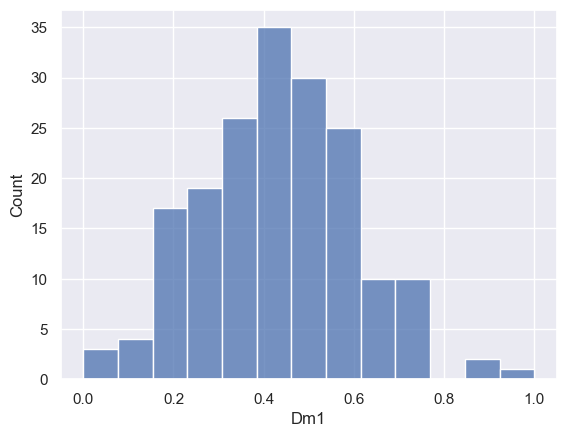

In [45]:
sns.histplot(dfProcessamento,x="Dm1")

### Avaliar classificação com as sugestões de quantidade ótima de grupos sugerida pelos métodos de avaliação

For n_clusters = 2 The average silhouette_score is : 0.2818340060605472


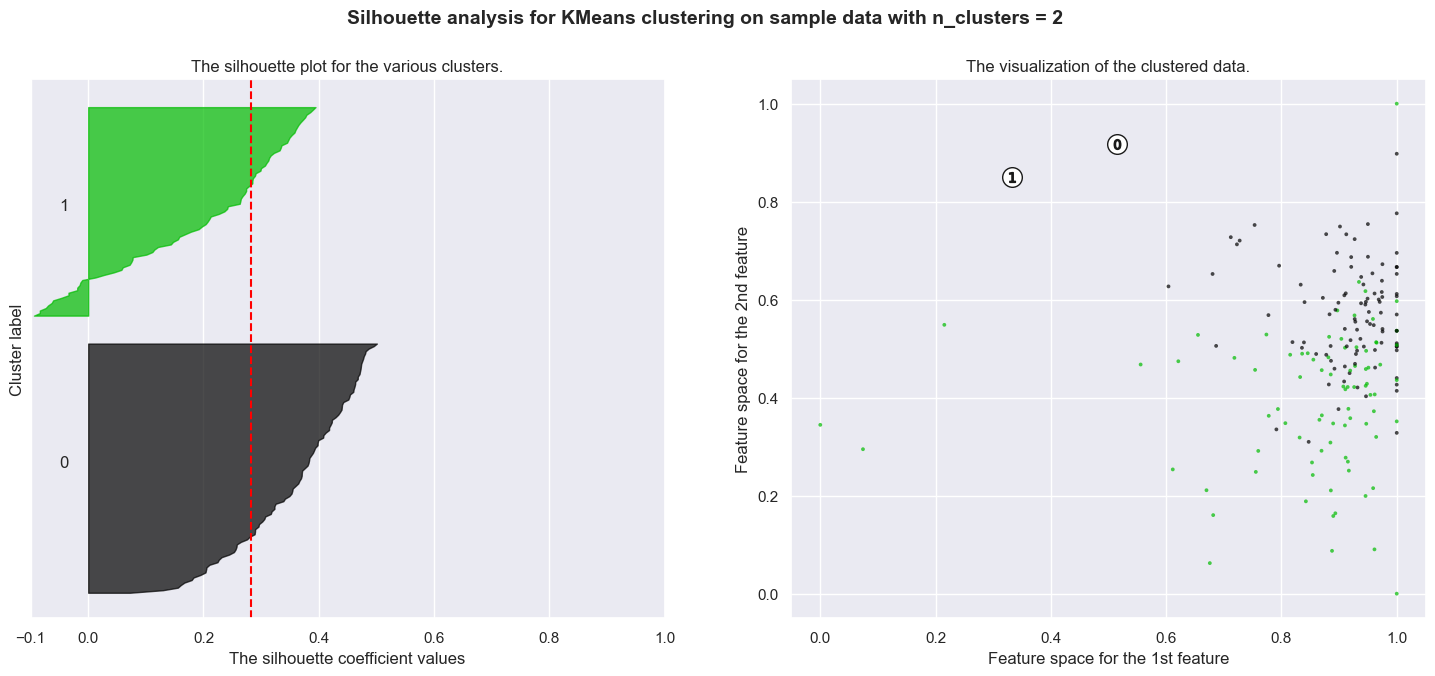

For n_clusters = 8 The average silhouette_score is : 0.13380180439229653


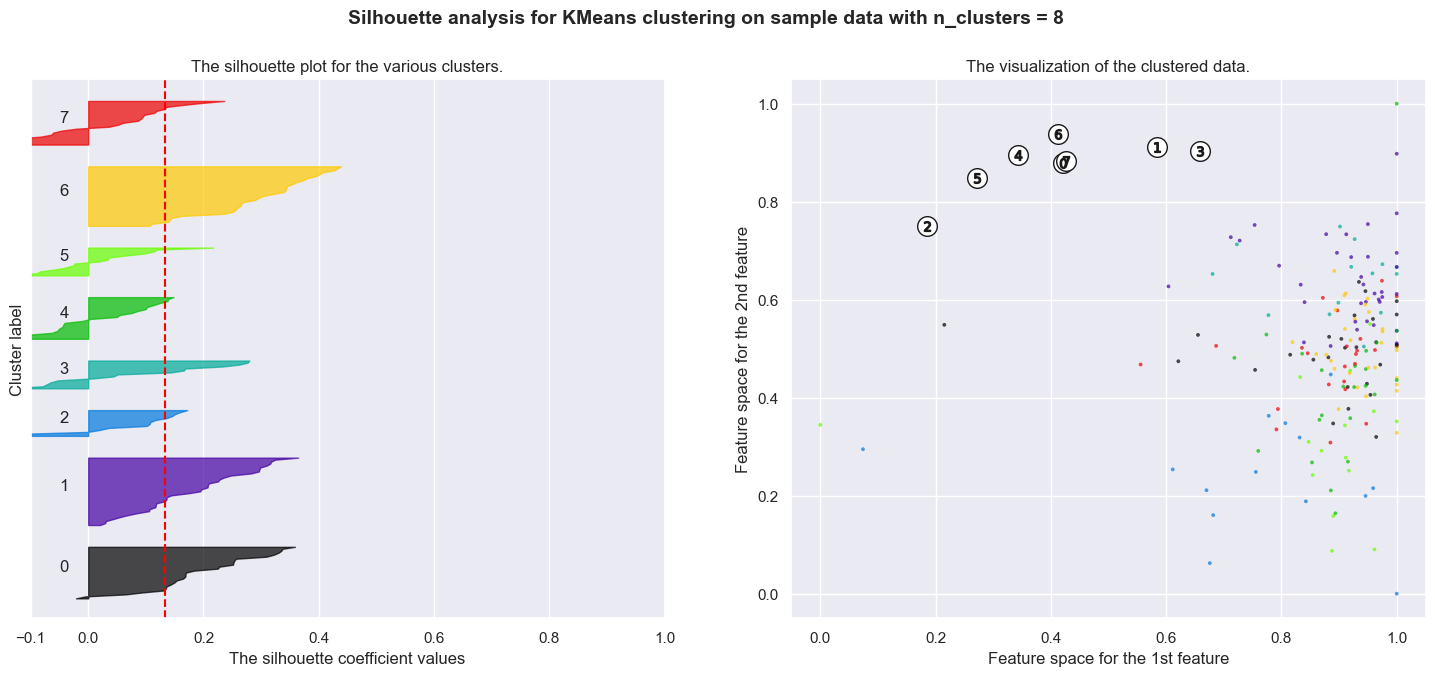

For n_clusters = 13 The average silhouette_score is : 0.1570385786237047


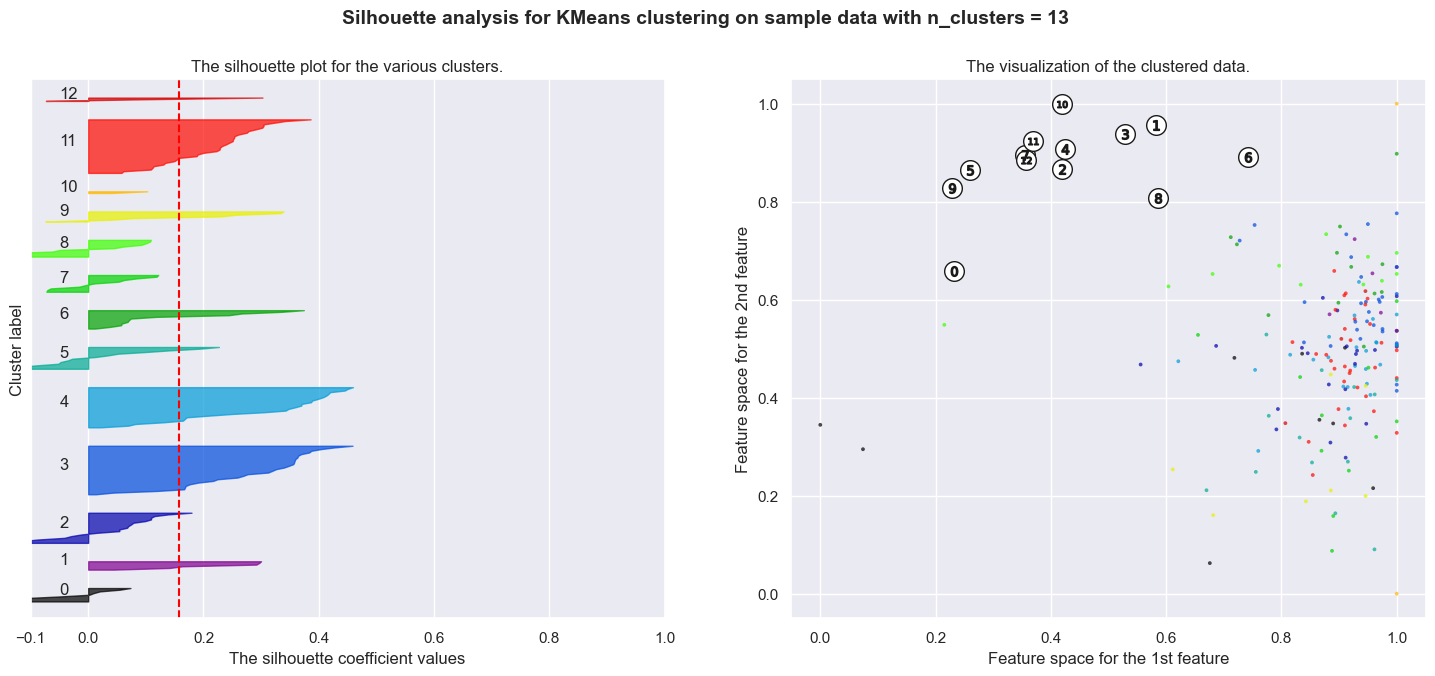

In [56]:

# Obter classificação com a quantidade de clusters sugerida pelos métodos seleção
sugestoesCluster=[2,8,13]
for k in sugestoesCluster:
    classificacao=avaliar_opcoes_arranjo(k,k,dfProcessamento[listaColunas])
    imprimir_grafico_analise_arranjo(classificacao[0],dfProcessamento[listaColunas])

In [57]:
# definir o range de clusters que serão avaliados
QTD_MIN_CLUSTERS=3
QTD_MAX_CLUSTERS=7

# Gerar dados sintéticos para classificação
# X=pd.DataFrame( np.random.rand(10000, 9))

# Resultado da avaliação 
resultados_pre_otimizacao= avaliar_opcoes_arranjo(QTD_MIN_CLUSTERS,QTD_MAX_CLUSTERS,dfProcessamento[listaColunas])
resultados_validos=obter_resultados_validos(resultados_pre_otimizacao)

resultados_validos

[]

For n_clusters = 3 The average silhouette_score is : 0.2306693666222132


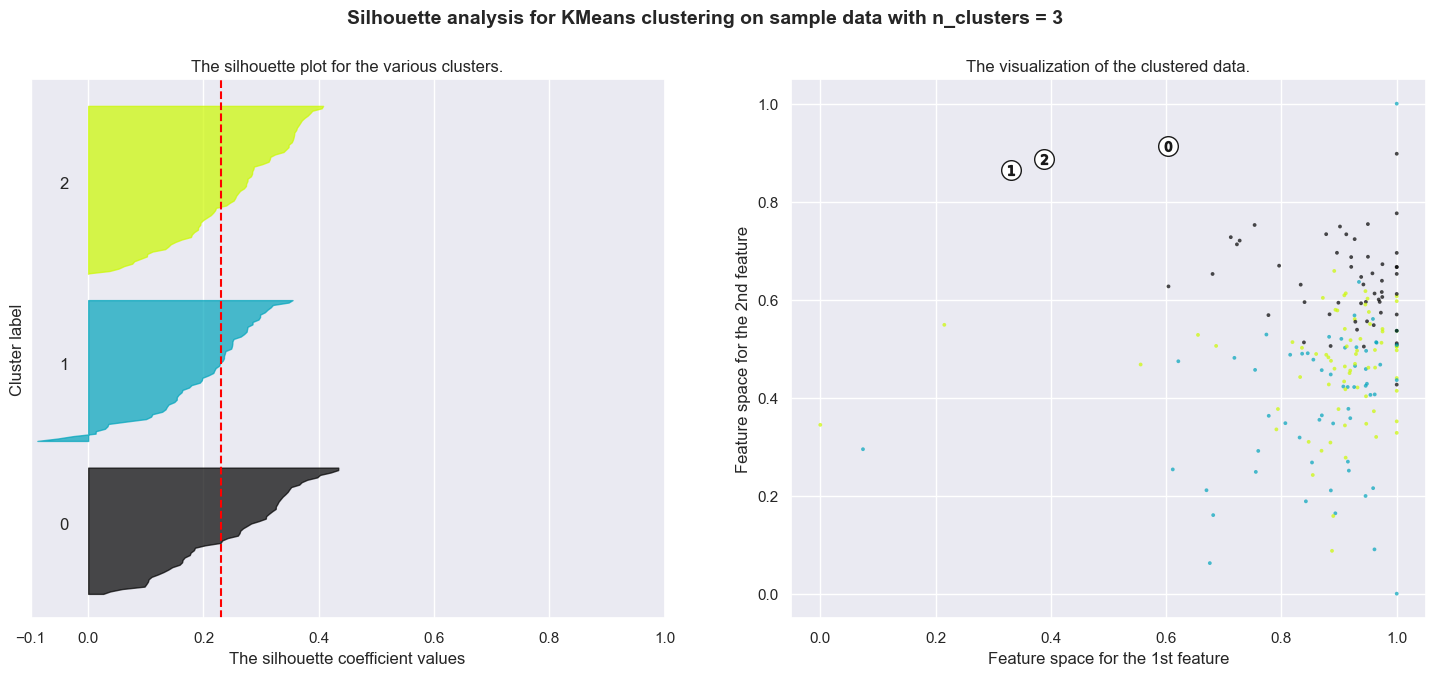

For n_clusters = 4 The average silhouette_score is : 0.18788838502058003


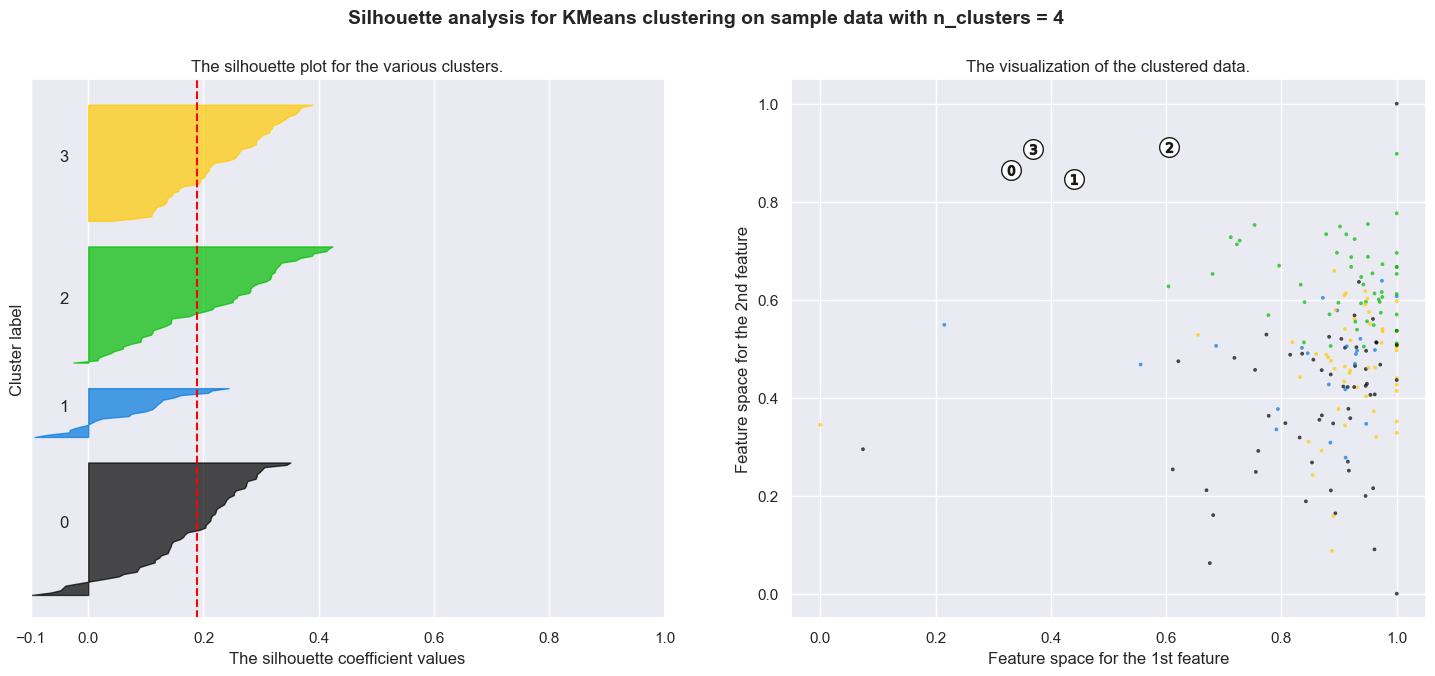

For n_clusters = 5 The average silhouette_score is : 0.1800985000377045


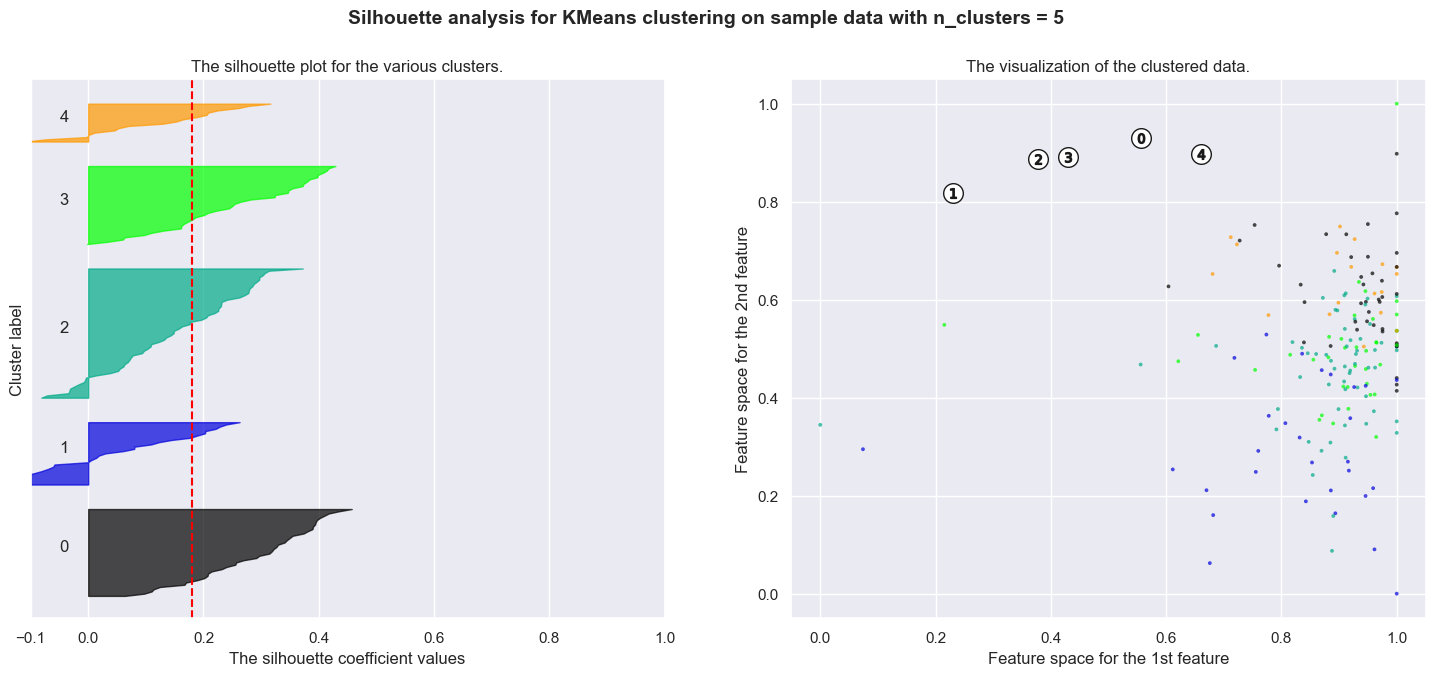

For n_clusters = 6 The average silhouette_score is : 0.1972763433820209


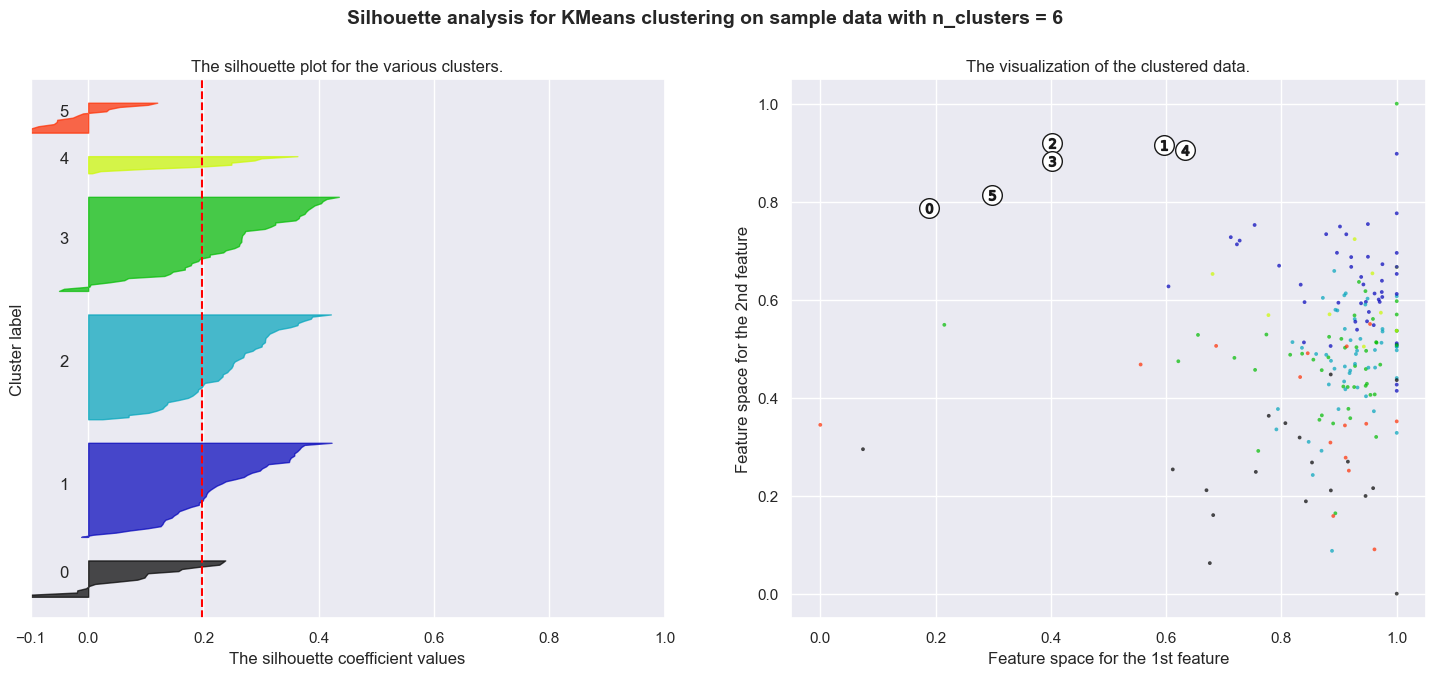

For n_clusters = 7 The average silhouette_score is : 0.1499708456920771


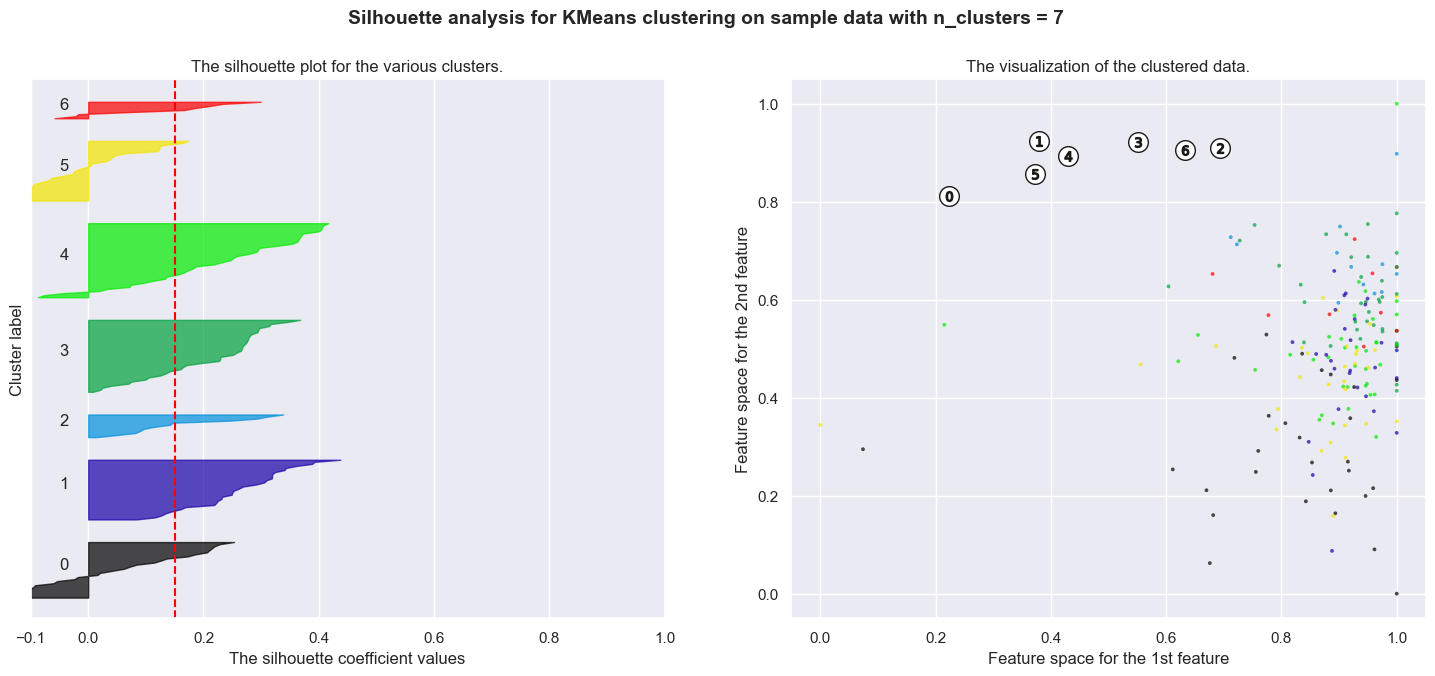

In [59]:
for arranjo in resultados_pre_otimizacao:
    imprimir_grafico_analise_arranjo(arranjo,dfProcessamento[listaColunas])
    

### Avaliação da Entropia das variáveis do dataset

<Axes: xlabel='entropia', ylabel='variavel'>

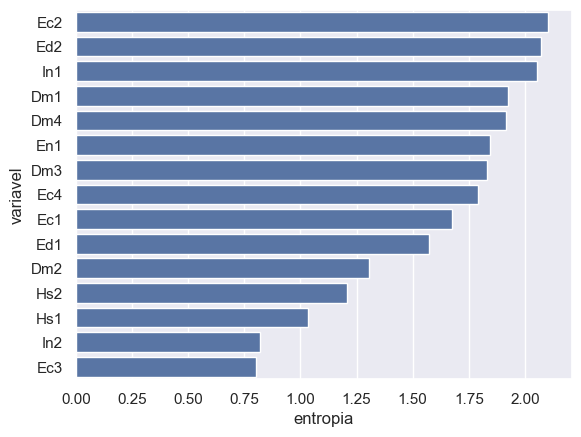

In [63]:
entropias = []
dfSemIndicador = dfProcessamento[listaColunas].round(1)
for col in range(dfSemIndicador.shape[1]):
    entropias.append({"variavel":dfSemIndicador.columns[col],"entropia":calcular_entropia(dfSemIndicador.iloc[:,col])})

dfEntropias = pd.DataFrame(entropias)
dfEntropias.sort_values(by=["entropia"],ascending=False,inplace=True)

sns.barplot(dfEntropias,y="variavel",x="entropia")


In [64]:
dfEntropias

,variavel,entropia
5,Ec2,2.103901
8,Ed2,2.073316
11,In1,2.052920
0,Dm1,1.925704
3,Dm4,1.913788
14,En1,1.845282
2,Dm3,1.831871
13,Ec4,1.792483
4,Ec1,1.677028
7,Ed1,1.574049


In [65]:
resultados = avaliar_opcoes_arranjo(
    QTD_MIN_CLUSTERS, QTD_MAX_CLUSTERS, dfProcessamento[listaColunas]
)
resultadosValidos = obter_resultados_validos(resultados)
melhorArranjo = selecionar_melhor_opcao_arranjo(resultadosValidos)

indexEntropia = 0
iteracao = 0

variaveisExcluidas = []
sumarioIteracoes = [
    {
        "iteracao": iteracao,
        "resultadosValidos": len(resultadosValidos),
        "variavel_excluida": "",
        "entropia": "",
    }
]
qtdVariaveis = len(listaColunas)

while melhorArranjo is None:
    iteracao += 1 
    if qtdVariaveis < 3:
        print(
            f"{iteracao} - SEM RESULTADOS VÁLIDOS: Dataset após a exclusão das variáveis não encontrou um resultado."
        )
        break
    
    maiorEntropia = dfEntropias.iloc[indexEntropia]
    indexEntropia += 1
    
    # Excluir varíavel com menor entropia
    variaveisExcluidas.append(maiorEntropia["variavel"])
    colunasClassificacao = list(set(listaColunas) - set(variaveisExcluidas))
    
    dfResultado = dfProcessamento[colunasClassificacao]
    qtdVariaveis = dfResultado.shape[1]
    
    # print(f"{iteracao} - SEM RESULTADOS VÁLIDOS: Analisar a entropia das variáveis.")
    # print(f"Excluir a variável '{maiorEntropia['variavel']}' do dataset ")

    # Refazer o K-means utilizando o novo dataset sem a variável com a menor entropia
    resultados = avaliar_opcoes_arranjo(
        QTD_MIN_CLUSTERS, QTD_MAX_CLUSTERS, dfResultado
    )
    resultadosValidos = obter_resultados_validos(resultados)
    melhorArranjo = selecionar_melhor_opcao_arranjo(resultadosValidos)

    dados_iteracao = {
        "iteracao": iteracao,
        "resultadosValidos": len(resultadosValidos),
        "variavel_excluida": maiorEntropia["variavel"],
        "entropia": maiorEntropia["entropia"],
    }

    sumarioIteracoes.append(dados_iteracao)



display(HTML(f"<h3> \o/ Melhor arranjo encontrado após {iteracao-1} iterações!</h3>"))

imprimir_dados_arranjo(melhorArranjo)

0.6194603648725546 0.6194603648725546


For n_clusters = 4 The average silhouette_score is : 0.6194603648725546


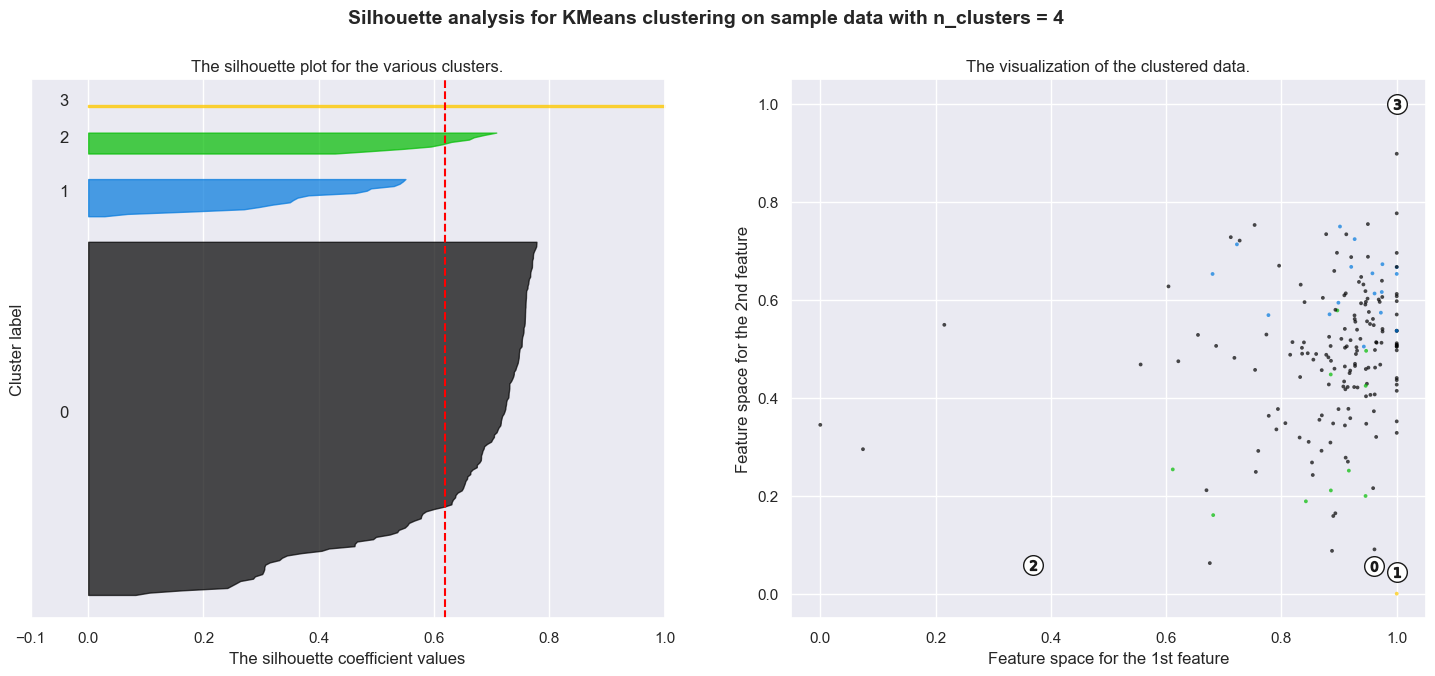

In [67]:
imprimir_grafico_analise_arranjo(melhorArranjo,dfProcessamento[listaColunas])

In [68]:
# Ver detalhes das iterações da análise de entropia
dfIteracoes=pd.DataFrame(sumarioIteracoes)
dfIteracoes

,iteracao,resultadosValidos,variavel_excluida,entropia
0,0,0,,
1,1,0,Ec2,2.103901
2,2,0,Ed2,2.073316
3,3,0,In1,2.05292
4,4,0,Dm1,1.925704
5,5,0,Dm4,1.913788
6,6,0,En1,1.845282
7,7,0,Dm3,1.831871
8,8,0,Ec4,1.792483
9,9,0,Ec1,1.677028


In [75]:
# Variáveis restantes após otimização
variaveisRestantes = list(set(listaColunas)-set(variaveisExcluidas))
variaveisRestantes

['Hs1', 'In2', 'Dm2', 'Hs2', 'Ec3']

In [76]:
# Ver os resultados válidos ao final das análises
[imprimir_dados_arranjo(r) for r in resultadosValidos]

[None, None, None, None]

In [77]:
[imprimir_dados_arranjo(r) for r in resultados]

[None, None, None, None, None]

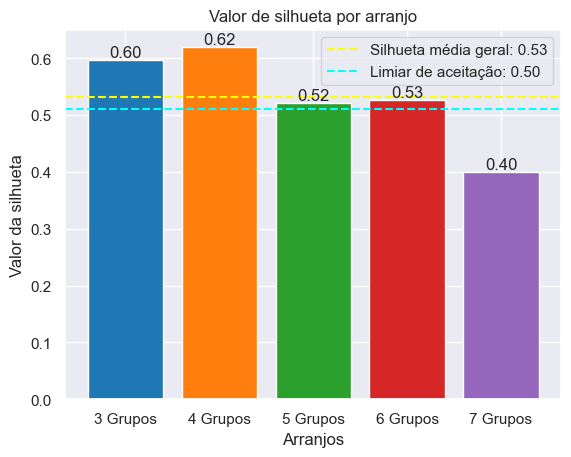

In [78]:

silhuetas=[r["silhueta_media"]for r in resultados]
nomesArranjo=[r["arranjo"]for r in resultados]

silhuetaMediaGeral = np.mean(silhuetas)

cores = [a[0] for a in mcolors.TABLEAU_COLORS.items()][:len(nomesArranjo)]

fig, ax = plt.subplots()
bar_container = ax.bar(nomesArranjo, silhuetas,color=cores)

# Adicionar uma linha para indicar a média geral da silhueta
ax.axhline(y=silhuetaMediaGeral, color='yellow', linestyle='--', label=f'Silhueta média geral: {silhuetaMediaGeral:.2f}')

# Adicionar uma linha para indicar a média geral da silhueta
ax.axhline(y=0.51, color='cyan', linestyle='--', label=f'Limiar de aceitação: {0.50:.2f}')

# Adicionar legenda para as linhas
ax.legend()

ax.set(ylabel='Valor da silhueta', title='Valor de silhueta por arranjo',xlabel="Arranjos")
ax.bar_label(bar_container, fmt='{:,.2f}')

plt.show()

### Salvar arquivo com resultado da classificação

In [80]:
variaveisResultado = ["Cod_setor"] + listaColunas
dfResultado=dfOriginal[variaveisResultado]
dfResultado["Grupo"]=pd.Series(melhorArranjo["rotulos"])

# dfArquivo.to_csv("dataset_classificado.csv",sep=";")
dfResultado

,Cod_setor,Dm1,Dm2,Dm3,Dm4,Ec1,Ec2,Ec3,Ed1,Ed2,Hs1,Hs2,In1,In2,Ec4,En1,Grupo
0,410940105000001,0.693124,0.883441,0.570118,0.920326,0.940887,1.000000,1.000000,1.000000,0.984436,1.000000,1.000000,0.911949,0.069303,0.485336,0.819315,1
1,410940105000002,0.906000,0.777440,0.568458,0.907551,0.723362,0.880554,0.418279,1.000000,0.933081,1.000000,0.956108,0.969708,0.086990,0.675887,0.933910,1
2,410940105000003,0.714812,0.712126,0.727527,0.870477,0.816013,0.813366,0.093626,1.000000,0.988700,1.000000,0.291103,0.889530,0.070139,0.869780,0.908084,0
3,410940105000004,0.685600,0.901545,0.749280,0.911010,0.890011,0.839647,0.189392,1.000000,0.986343,1.000000,0.452706,0.944219,0.047353,0.872219,0.919209,1
4,410940105000005,0.883110,0.722763,0.712888,0.786313,0.816978,0.744081,0.280399,0.650567,1.000000,1.000000,0.451960,1.000000,0.041789,1.000000,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,410940105000188,0.405701,0.934455,0.636249,0.697463,0.820363,0.222199,0.000000,1.000000,0.673281,1.000000,0.000000,0.199997,0.073957,0.268284,0.538857,0
178,410940105000189,0.689523,1.000000,1.000000,0.154858,1.000000,0.451993,0.000000,1.000000,0.372557,1.000000,0.000000,0.000000,1.000000,0.435096,0.255244,3
179,410940105000190,0.147641,1.000000,0.000000,0.229461,0.541156,0.390893,0.000000,1.000000,0.173626,1.000000,0.000000,0.000000,1.000000,0.269255,0.187330,3
180,410940105000191,0.000000,1.000000,0.435858,0.198216,1.000000,0.000000,0.000000,1.000000,0.566473,1.000000,0.000000,0.000000,0.044780,0.105261,0.000000,0


In [88]:
cluster=melhorArranjo
dfRotulosSilhuetas = pd.DataFrame(zip(cluster["silhuetas"],cluster["rotulos"]),columns=["silhuetas","rotulos"])
dfRotulosSilhuetas.sort_values(by=["rotulos","silhuetas"],inplace=True)
rotulos = list(dfRotulosSilhuetas.groupby(["rotulos"]).count().index)
rotulos

[0, 1, 2, 3]

In [89]:
dfRotulosSilhuetas

,silhuetas,rotulos
142,0.081949,0
109,0.106055,0
103,0.163667,0
70,0.241334,0
2,0.248903,0
...,...,...
68,0.669188,2
51,0.687117,2
90,0.707894,2
178,1.000000,3


In [115]:

rows,cols = dfRotulosSilhuetas.shape
fig = make_subplots(rows=1, cols=len(rotulos), shared_yaxes=True)

for rotulo in rotulos:
    fig.add_trace(
        go.Bar(y=dfRotulosSilhuetas["silhuetas"][dfRotulosSilhuetas["rotulos"]==rotulo], name=f"G{rotulo+1}"), 1, rotulo+1
    )
# fig.add_trace(
#     go.Bar(y=df["silhuetas"][df["rotulos"]==1], name="2"),
#     1,
#     2,
# )

# fig.add_trace(
#     go.Bar(y=df["silhuetas"][df["rotulos"]]==2, name="3"),
#     1,
#     3,
# )

fig.add_hline(y=cluster["silhueta_media"],
                  line_width=2,
                  line_dash="dash",
                  line_color="red")

fig.show()

In [129]:
dfResumoClassificacao = pd.DataFrame(cluster["resumo_classificacao"])         
dfResumoClassificacao["nome_grupo"] = "G"+(dfResumoClassificacao["grupo"]).astype(str)      

fig = px.bar(dfResumoClassificacao, x="nome_grupo", y="qtd", color="nome_grupo")  
fig.show()

In [130]:
silhuetas=[r["silhueta_media"]for r in resultados]
nomesArranjo=[r["arranjo"] for r in resultados]

dfRotulosSilhuetas=pd.DataFrame({'arranjo':nomesArranjo,'silhueta_media':silhuetas})

fig = px.bar(dfRotulosSilhuetas, x="arranjo", y="silhueta_media", color="arranjo")  

fig.add_hline(y=dfRotulosSilhuetas["silhueta_media"].mean(),
              line_width=2,          
              line_dash="dash",      
              line_color="cyan",
              annotation_text="Silhueta média geral") 

fig.add_hline(y=0.5,
              line_width=2,          
              line_dash="dash",      
              line_color="yellow",
              annotation_text="Limiar de aceitação")   

fig



In [135]:
variaveisRestantes

['Hs1', 'In2', 'Dm2', 'Hs2', 'Ec3']

In [184]:
# Gerar relatório ANOVA
dadosAnova = []
dfResultadoAnova = dfResultado[ variaveisRestantes + ["Grupo"]]
for grupo in dfResultado["Grupo"].unique():
    anova = dfResultadoAnova[dfResultadoAnova["Grupo"] == grupo].describe().round(2)
    dadosAnova.append(np.append(anova.iloc[[1]].values[0][:-1], f"G{grupo+1}"))
    # for i,col in enumerate(cols[1::]):
    #     dados_anova.append({"grupo":f"G{grupo}" ,"variavel":col,"media":anova.iloc[[1]].values[0][i]})

dfAnova = pd.DataFrame(dadosAnova, columns=dfResultadoAnova.columns).round(2)
dfAnova

,Hs1,In2,Dm2,Hs2,Ec3,Grupo
0,1.0,0.04,0.91,0.58,0.32,G2
1,0.96,0.06,0.88,0.05,0.02,G1
2,0.37,0.06,0.86,0.0,0.01,G3
3,1.0,1.0,1.0,0.0,0.0,G4


In [151]:
#Tabela com o resultado do agrupamento para as variáveis restantes
fig = go.Figure(data=[go.Table(
    header=dict(values=dfResultadoAnova.columns),
    cells=dict(values=dfResultadoAnova.round(2).values.T))
                     ])
fig.show()


In [159]:
#Correlação entre as variáveis
px.imshow(dfProcessamento.corr().round(2).abs(),text_auto=True,aspect="auto")

In [260]:
def calcular_percentual_outliers(dataset, grupo):
    dadosOutliers = []
    for col in dataset.columns:
        q1 = dataset[col].quantile(0.25)
        q3 = dataset[col].quantile(0.75)
        iqr = q3 - q1  # Interquartile range
        fence_low = q1 - 1.5 * iqr
        fence_high = q3 + 1.5 * iqr
        dfOutliers = dataset.loc[
            (dataset[col] < fence_low) | (dataset[col] > fence_high)
        ]
        dadosOutliers.append(
            {
                "grupo": grupo,
                "variavel": col,
                "qtd": len(dataset),
                "qtd_outliers": len(dfOutliers),
                "perc_outliers": round(len(dfOutliers) / len(dataset[col]), 3),
                "q1": q1,
                "q3": q3,
                "fence_low": fence_low,
                "fence_high": fence_high,
            }
        )

    return dadosOutliers


dadosOutliers = []
for grupo in dfResultado["Grupo"].unique():
    datasetGrupo = dfResultado[dfResultado["Grupo"] == grupo]
    dataset = datasetGrupo[colunasClassificacao]
    outliers = calcular_percentual_outliers(dataset, grupo)
    dadosOutliers = dadosOutliers+outliers


dfOutliers = pd.DataFrame(dadosOutliers)

dfOutliers.sort_values(by=["variavel","grupo"])

,grupo,variavel,qtd,qtd_outliers,perc_outliers,q1,q3,fence_low,fence_high
7,0,Dm2,153,12,0.078,0.865865,0.960085,0.724535,1.101415
2,1,Dm2,17,3,0.176,0.898799,0.974051,0.785922,1.086929
12,2,Dm2,10,2,0.200,0.853183,0.938664,0.724962,1.066886
17,3,Dm2,2,0,0.000,1.000000,1.000000,1.000000,1.000000
9,0,Ec3,153,12,0.078,0.000000,0.032718,-0.049078,0.081796
4,1,Ec3,17,1,0.059,0.189392,0.383674,-0.102032,0.675098
14,2,Ec3,10,2,0.200,0.000000,0.000000,0.000000,0.000000
19,3,Ec3,2,0,0.000,0.000000,0.000000,0.000000,0.000000
5,0,Hs1,153,12,0.078,0.933127,1.000000,0.832817,1.100310
0,1,Hs1,17,0,0.000,1.000000,1.000000,1.000000,1.000000


In [261]:
dfOutliersGrupo =  dfOutliers.pivot(index="variavel",columns="grupo",values="perc_outliers")
dfOutliersGrupo

grupo,0,1,2,3
variavel,,,,
Dm2,0.078,0.176,0.2,0.0
Ec3,0.078,0.059,0.2,0.0
Hs1,0.078,0.000,0.2,0.0
Hs2,0.085,0.000,0.1,0.0
In2,0.020,0.000,0.0,0.0


In [272]:
grupos = rotulos
titulos = []
for v in variaveisRestantes:
    for g in grupos:
        titulos.append(f"G{g+1}")

print(grupos, variaveisRestantes)

fig = make_subplots(
    rows=len(variaveisRestantes),
    cols=len(grupos),
    subplot_titles=tuple(titulos),
    shared_xaxes=True,
)
i = 1
for v in variaveisRestantes:
    j = 1
    for g in grupos:
        data = dfResultado[dfResultado["Grupo"] == g].round(2)
        fig.add_trace(go.Box(x=data["Grupo"], y=data[v], name=f"{v}",fillcolor="antiquewhite",line=dict(color="#7f7f7f")), row=i, col=j)
        j += 1
    i += 1

fig.update_layout(
    height=960, width=960, title_text="Gupos x Subindicadores", showlegend=False
)
fig.show()

[0, 1, 2, 3] ['Hs1', 'In2', 'Dm2', 'Hs2', 'Ec3']


In [275]:
dfResultado[dfResultado["Grupo"]==0][colunasClassificacao]

,Hs1,In2,Dm2,Hs2,Ec3
2,1.000000,0.070139,0.712126,0.291103,0.093626
12,1.000000,0.092834,0.942194,0.166166,0.176556
13,1.000000,0.025217,0.896296,0.262508,0.129549
14,1.000000,0.012705,0.840069,0.287209,0.106218
15,1.000000,0.036534,0.882200,0.000000,0.000000
...,...,...,...,...,...
174,1.000000,0.046489,1.000000,0.233495,0.044740
176,1.000000,0.036649,0.869530,0.000000,0.000000
177,1.000000,0.073957,0.934455,0.000000,0.000000
180,1.000000,0.044780,1.000000,0.000000,0.000000


In [278]:
fig = px.box(dfResultado[dfResultado["Grupo"]==0],x="Grupo",y="Hs2",color="Grupo",points="all")
fig.show()